# QTau with Dask: Distributed Computing Examples

This notebook demonstrates how to use QTau with the **Dask** execution engine for distributed computing tasks.

## Overview

Dask is a flexible parallel computing library that integrates seamlessly with QTau. It's ideal for:
- Data-parallel computations
- Task scheduling with complex dependencies
- Integration with pandas, NumPy, and scikit-learn workflows

### Table of Contents
1. [Setup and Configuration](#setup)
2. [Basic Dask Task Distribution](#basic)
3. [Parallel Data Processing](#data-processing)
4. [Distributed NumPy Operations](#numpy)
5. [Task Dependencies and DAGs](#dag)
6. [Monitoring and Visualization](#monitoring)

## 1. Setup and Configuration <a id="setup"></a>

In [1]:
!pip install matplotlib==3.10.8
!pip install seaborn==0.13.2

In [2]:
# Import required libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# QTau imports
from qtau.qtau_compute_service import QTauComputeService, ExecutionEngine

print("Imports successful!")
print(f"Current time: {datetime.now()}")

Imports successful!
Current time: 2025-12-23 21:48:54.281623


In [3]:
# Configuration for Dask execution
RESOURCE_URL = "ssh://localhost"
WORKING_DIRECTORY = os.path.join(os.environ["HOME"], "work", "qtau_dask")

# Create working directory
os.makedirs(WORKING_DIRECTORY, exist_ok=True)

# Dask qtau configuration
qtau_compute_description_dask = {
    "resource": RESOURCE_URL,
    "working_directory": WORKING_DIRECTORY,
    "type": "dask",
    "number_of_nodes": 1,
    "cores_per_node": 4,
}

print("Dask Configuration:")
for key, value in qtau_compute_description_dask.items():
    print(f"  {key}: {value}")

Dask Configuration:
  resource: ssh://localhost
  working_directory: /home/sondn/work/qtau_dask
  type: dask
  number_of_nodes: 1
  cores_per_node: 4


### Starting QTau with Dask (Production Code)

```python
# Initialize QTauComputeService with Dask engine
pcs = QTauComputeService(working_directory=WORKING_DIRECTORY)

# Create and wait for qtau
qtau = pcs.create_qtau(qtau_compute_description=qtau_compute_description_dask)
qtau.wait()

# Get Dask client for advanced operations
dask_client = qtau.get_client()
print(dask_client.scheduler_info())
```

## 2. Basic Dask Task Distribution <a id="basic"></a>

This section demonstrates basic task submission and result collection with Dask.

In [4]:
# Define sample computational tasks
def compute_prime_count(n):
    """Count prime numbers up to n using Sieve of Eratosthenes."""
    if n < 2:
        return 0
    sieve = [True] * (n + 1)
    sieve[0] = sieve[1] = False
    for i in range(2, int(n**0.5) + 1):
        if sieve[i]:
            for j in range(i*i, n + 1, i):
                sieve[j] = False
    return sum(sieve)

def matrix_operation(size, operation='multiply'):
    """Perform matrix operations."""
    A = np.random.rand(size, size)
    B = np.random.rand(size, size)
    if operation == 'multiply':
        result = np.dot(A, B)
    elif operation == 'eigenvalue':
        result = np.linalg.eigvals(A)
    elif operation == 'svd':
        result = np.linalg.svd(A, compute_uv=False)
    return result.sum() if hasattr(result, 'sum') else sum(result)

def simulate_data_processing(chunk_size):
    """Simulate data processing on a chunk."""
    data = np.random.randn(chunk_size)
    # Simulate various statistics
    return {
        'mean': np.mean(data),
        'std': np.std(data),
        'min': np.min(data),
        'max': np.max(data),
        'sum': np.sum(data)
    }

In [5]:
# Simulate distributed task execution
np.random.seed(42)

# Prime counting tasks
n_values = [10000, 50000, 100000, 200000, 500000]
prime_results = []

for n in n_values:
    start = time.time()
    count = compute_prime_count(n)
    elapsed = time.time() - start
    prime_results.append({
        'n': n,
        'prime_count': count,
        'execution_time': elapsed,
        'primes_per_second': count / elapsed if elapsed > 0 else 0
    })

prime_df = pd.DataFrame(prime_results)
prime_df

,n,prime_count,execution_time,primes_per_second
0,10000,1229,0.000336,3.661079e+06
1,50000,5133,0.001814,2.829088e+06
2,100000,9592,0.003840,2.497936e+06
3,200000,17984,0.007957,2.260221e+06
4,500000,41538,0.023127,1.796095e+06


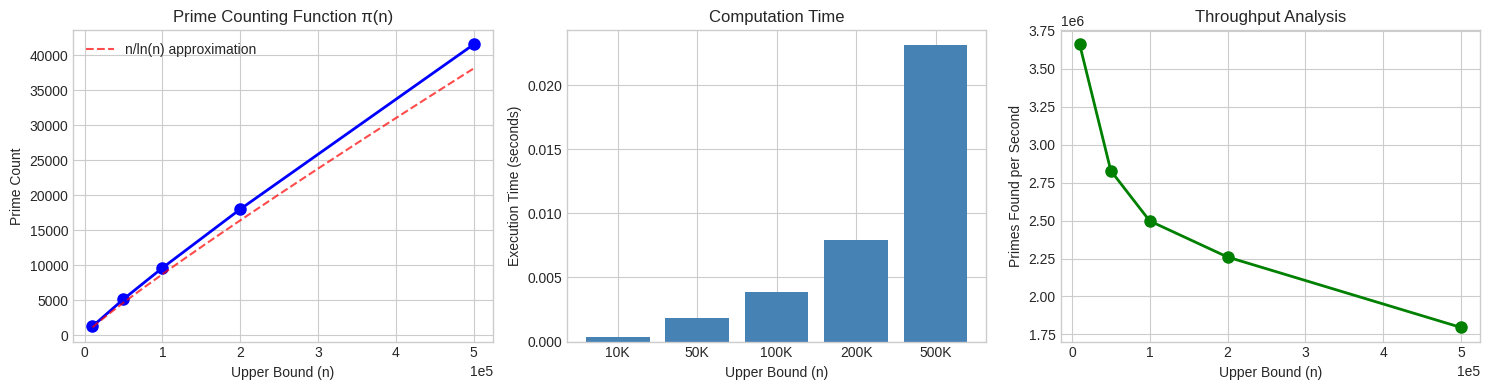

In [6]:
# Visualize prime counting results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Prime count vs n
ax1 = axes[0]
ax1.plot(prime_df['n'], prime_df['prime_count'], 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Upper Bound (n)')
ax1.set_ylabel('Prime Count')
ax1.set_title('Prime Counting Function π(n)')
ax1.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Add theoretical approximation n/ln(n)
n_theory = np.linspace(10000, 500000, 100)
pi_approx = n_theory / np.log(n_theory)
ax1.plot(n_theory, pi_approx, 'r--', alpha=0.7, label='n/ln(n) approximation')
ax1.legend()

# 2. Execution time vs n
ax2 = axes[1]
ax2.bar(range(len(prime_df)), prime_df['execution_time'], color='steelblue')
ax2.set_xticks(range(len(prime_df)))
ax2.set_xticklabels([f'{n/1000:.0f}K' for n in prime_df['n']])
ax2.set_xlabel('Upper Bound (n)')
ax2.set_ylabel('Execution Time (seconds)')
ax2.set_title('Computation Time')

# 3. Throughput
ax3 = axes[2]
ax3.plot(prime_df['n'], prime_df['primes_per_second'], 'go-', linewidth=2, markersize=8)
ax3.set_xlabel('Upper Bound (n)')
ax3.set_ylabel('Primes Found per Second')
ax3.set_title('Throughput Analysis')
ax3.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))

plt.tight_layout()
plt.savefig('dask_prime_counting.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Parallel Data Processing <a id="data-processing"></a>

Demonstrates how to process data in parallel chunks using Dask with QTau.

In [7]:
# Simulate parallel data processing
n_chunks = 16
chunk_size = 100000

# Process chunks (simulating distributed execution)
chunk_results = []
np.random.seed(42)

for i in range(n_chunks):
    start = time.time()
    result = simulate_data_processing(chunk_size)
    elapsed = time.time() - start
    result['chunk_id'] = i
    result['processing_time'] = elapsed
    chunk_results.append(result)

chunks_df = pd.DataFrame(chunk_results)
chunks_df.head(10)

,mean,std,min,max,sum,chunk_id,processing_time
0,0.000967,1.000901,-4.465604,4.479084,96.686814,0,0.001849
1,0.000981,0.998934,-4.374043,4.562115,98.103404,1,0.001659
2,-0.001508,0.999847,-4.413886,4.219366,-150.833322,2,0.001657
3,-0.000129,1.001589,-4.312973,3.918185,-12.904247,3,0.001645
4,-0.006141,1.001055,-4.829436,4.301848,-614.147438,4,0.001661
5,-0.002445,1.002256,-4.227232,4.678949,-244.543934,5,0.001649
6,0.003123,0.998579,-4.319465,4.526784,312.281979,6,0.001662
7,0.001873,1.000406,-4.142430,3.989945,187.322107,7,0.001653
8,-0.003374,1.000077,-3.928834,3.980280,-337.441130,8,0.001735
9,-0.009343,0.998161,-4.596948,4.616384,-934.280687,9,0.001811


In [8]:
# Aggregate results (like MapReduce)
total_sum = chunks_df['sum'].sum()
global_mean = chunks_df['mean'].mean()
global_std = np.sqrt((chunks_df['std']**2).mean())  # Approximate combined std
global_min = chunks_df['min'].min()
global_max = chunks_df['max'].max()

print("Aggregated Statistics Across All Chunks:")
print(f"  Total Sum: {total_sum:,.2f}")
print(f"  Global Mean: {global_mean:.6f}")
print(f"  Global Std: {global_std:.6f}")
print(f"  Global Min: {global_min:.6f}")
print(f"  Global Max: {global_max:.6f}")
print(f"  Total Data Points: {n_chunks * chunk_size:,}")

Aggregated Statistics Across All Chunks:
  Total Sum: -2,045.32
  Global Mean: -0.001278
  Global Std: 1.000917
  Global Min: -4.829436
  Global Max: 4.678949
  Total Data Points: 1,600,000


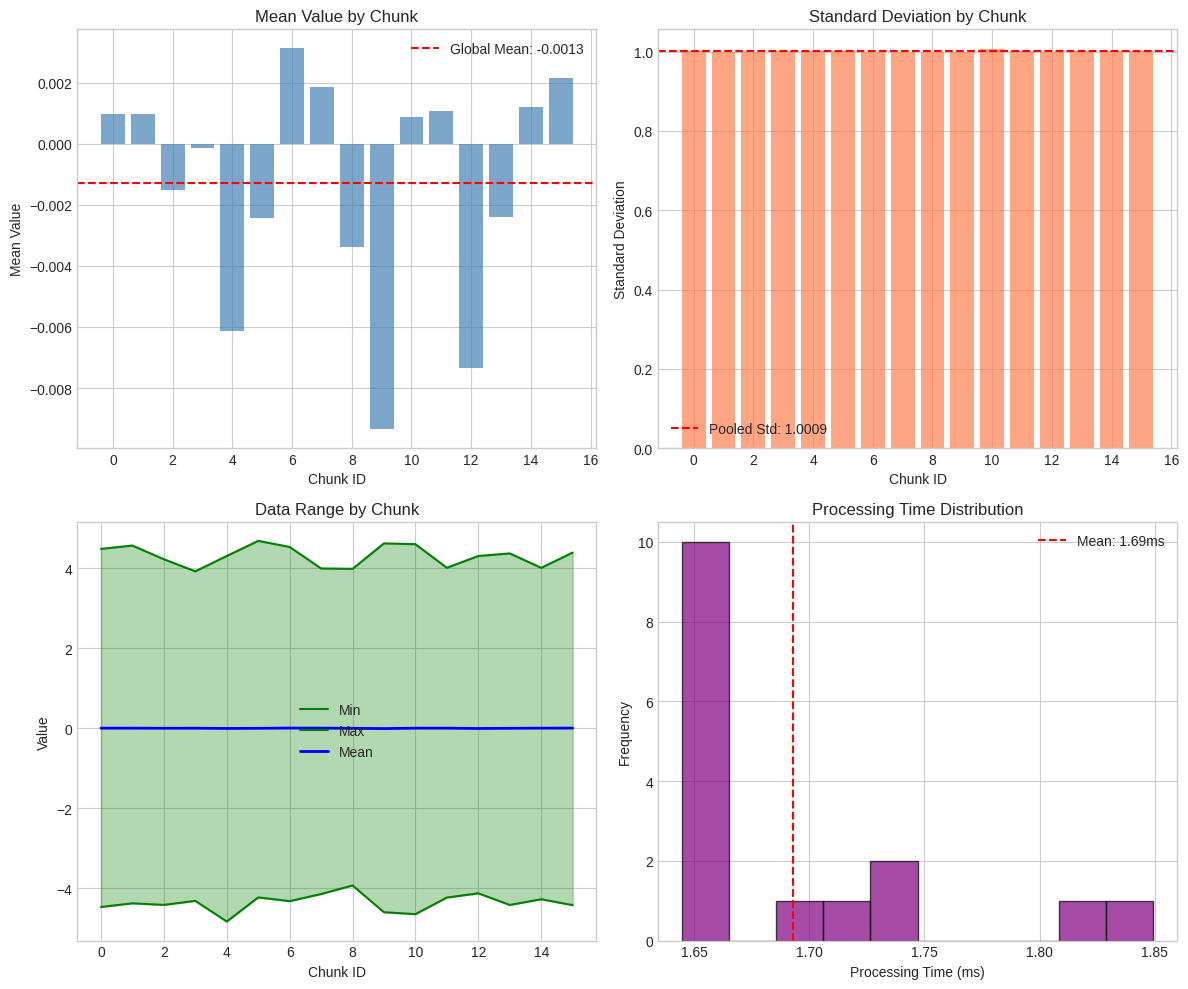

In [9]:
# Visualize chunk processing results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Mean by chunk
ax1 = axes[0, 0]
ax1.bar(chunks_df['chunk_id'], chunks_df['mean'], color='steelblue', alpha=0.7)
ax1.axhline(global_mean, color='red', linestyle='--', label=f'Global Mean: {global_mean:.4f}')
ax1.set_xlabel('Chunk ID')
ax1.set_ylabel('Mean Value')
ax1.set_title('Mean Value by Chunk')
ax1.legend()

# 2. Standard deviation by chunk
ax2 = axes[0, 1]
ax2.bar(chunks_df['chunk_id'], chunks_df['std'], color='coral', alpha=0.7)
ax2.axhline(global_std, color='red', linestyle='--', label=f'Pooled Std: {global_std:.4f}')
ax2.set_xlabel('Chunk ID')
ax2.set_ylabel('Standard Deviation')
ax2.set_title('Standard Deviation by Chunk')
ax2.legend()

# 3. Min/Max range by chunk
ax3 = axes[1, 0]
chunk_ids = chunks_df['chunk_id']
ax3.fill_between(chunk_ids, chunks_df['min'], chunks_df['max'], alpha=0.3, color='green')
ax3.plot(chunk_ids, chunks_df['min'], 'g-', label='Min')
ax3.plot(chunk_ids, chunks_df['max'], 'g-', label='Max')
ax3.plot(chunk_ids, chunks_df['mean'], 'b-', linewidth=2, label='Mean')
ax3.set_xlabel('Chunk ID')
ax3.set_ylabel('Value')
ax3.set_title('Data Range by Chunk')
ax3.legend()

# 4. Processing time distribution
ax4 = axes[1, 1]
ax4.hist(chunks_df['processing_time'] * 1000, bins=10, color='purple', alpha=0.7, edgecolor='black')
ax4.axvline(chunks_df['processing_time'].mean() * 1000, color='red', linestyle='--', 
            label=f'Mean: {chunks_df["processing_time"].mean()*1000:.2f}ms')
ax4.set_xlabel('Processing Time (ms)')
ax4.set_ylabel('Frequency')
ax4.set_title('Processing Time Distribution')
ax4.legend()

plt.tight_layout()
plt.savefig('dask_parallel_processing.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Distributed NumPy Operations <a id="numpy"></a>

Demonstrates distributed matrix operations commonly used in scientific computing.

In [10]:
# Matrix operation benchmarks
matrix_sizes = [100, 200, 300, 400, 500]
operations = ['multiply', 'eigenvalue', 'svd']

matrix_results = []

for size in matrix_sizes:
    for op in operations:
        start = time.time()
        result = matrix_operation(size, op)
        elapsed = time.time() - start
        matrix_results.append({
            'size': size,
            'operation': op,
            'execution_time': elapsed,
            'flops_estimate': size**3 / elapsed if elapsed > 0 else 0
        })

matrix_df = pd.DataFrame(matrix_results)
matrix_df.head(15)

,size,operation,execution_time,flops_estimate
0,100,multiply,0.000496,2.015523e+09
1,100,eigenvalue,0.004941,2.023887e+08
2,100,svd,0.004295,2.328487e+08
3,200,multiply,0.000869,9.210659e+09
4,200,eigenvalue,0.035642,2.244534e+08
5,200,svd,0.004672,1.712223e+09
6,300,multiply,0.002275,1.186818e+10
7,300,eigenvalue,0.062776,4.301033e+08
8,300,svd,0.009634,2.802708e+09
9,400,multiply,0.003469,1.844664e+10


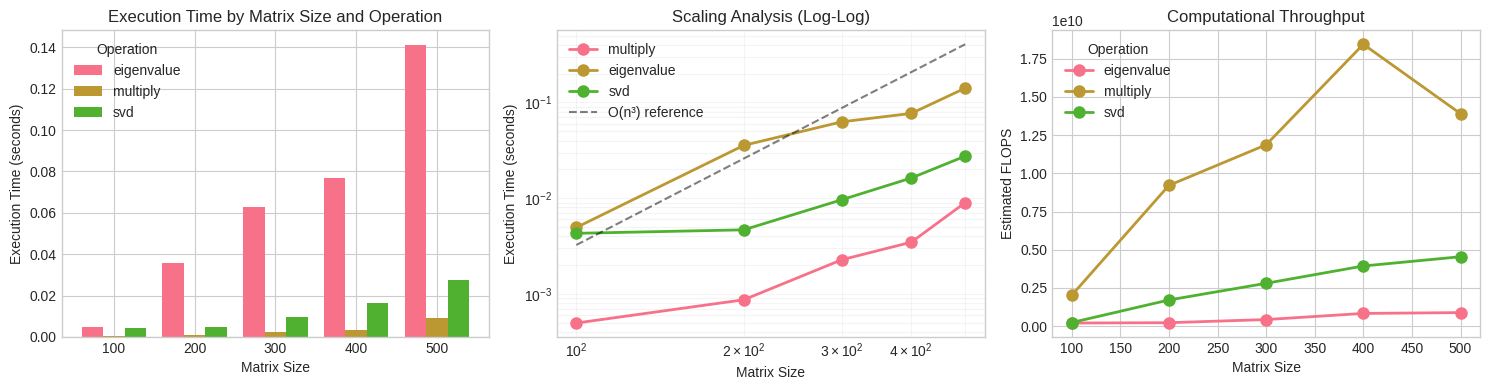

In [11]:
# Visualize matrix operation benchmarks
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Execution time by operation and size
ax1 = axes[0]
pivot_time = matrix_df.pivot(index='size', columns='operation', values='execution_time')
pivot_time.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_xlabel('Matrix Size')
ax1.set_ylabel('Execution Time (seconds)')
ax1.set_title('Execution Time by Matrix Size and Operation')
ax1.tick_params(axis='x', rotation=0)
ax1.legend(title='Operation')

# 2. Scaling analysis (log-log plot)
ax2 = axes[1]
for op in operations:
    op_data = matrix_df[matrix_df['operation'] == op]
    ax2.loglog(op_data['size'], op_data['execution_time'], 'o-', label=op, linewidth=2, markersize=8)

# Add O(n^3) reference line
sizes = np.array(matrix_sizes)
ref_line = (sizes/100)**3 * matrix_df[matrix_df['size']==100]['execution_time'].mean()
ax2.loglog(sizes, ref_line, 'k--', alpha=0.5, label='O(n³) reference')

ax2.set_xlabel('Matrix Size')
ax2.set_ylabel('Execution Time (seconds)')
ax2.set_title('Scaling Analysis (Log-Log)')
ax2.legend()
ax2.grid(True, which="both", ls="-", alpha=0.2)

# 3. Throughput comparison
ax3 = axes[2]
pivot_flops = matrix_df.pivot(index='size', columns='operation', values='flops_estimate')
pivot_flops.plot(kind='line', ax=ax3, marker='o', linewidth=2, markersize=8)
ax3.set_xlabel('Matrix Size')
ax3.set_ylabel('Estimated FLOPS')
ax3.set_title('Computational Throughput')
ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
ax3.legend(title='Operation')

plt.tight_layout()
plt.savefig('dask_matrix_operations.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Task Dependencies and DAGs <a id="dag"></a>

Dask excels at handling complex task dependencies. This section visualizes task execution DAGs.

In [12]:
# Simulate a DAG of dependent tasks
# Task structure:
# Level 0: Data loading (4 tasks)
# Level 1: Preprocessing (4 tasks, each depends on 1 load task)
# Level 2: Feature extraction (2 tasks, each depends on 2 preprocess tasks)
# Level 3: Model training (1 task, depends on all feature tasks)
# Level 4: Evaluation (1 task, depends on model training)

dag_tasks = [
    # Level 0: Data loading
    {'task_id': 'load_0', 'level': 0, 'dependencies': [], 'duration': 0.5},
    {'task_id': 'load_1', 'level': 0, 'dependencies': [], 'duration': 0.6},
    {'task_id': 'load_2', 'level': 0, 'dependencies': [], 'duration': 0.4},
    {'task_id': 'load_3', 'level': 0, 'dependencies': [], 'duration': 0.55},
    # Level 1: Preprocessing
    {'task_id': 'preprocess_0', 'level': 1, 'dependencies': ['load_0'], 'duration': 0.8},
    {'task_id': 'preprocess_1', 'level': 1, 'dependencies': ['load_1'], 'duration': 0.7},
    {'task_id': 'preprocess_2', 'level': 1, 'dependencies': ['load_2'], 'duration': 0.9},
    {'task_id': 'preprocess_3', 'level': 1, 'dependencies': ['load_3'], 'duration': 0.75},
    # Level 2: Feature extraction
    {'task_id': 'features_0', 'level': 2, 'dependencies': ['preprocess_0', 'preprocess_1'], 'duration': 1.2},
    {'task_id': 'features_1', 'level': 2, 'dependencies': ['preprocess_2', 'preprocess_3'], 'duration': 1.1},
    # Level 3: Model training
    {'task_id': 'train', 'level': 3, 'dependencies': ['features_0', 'features_1'], 'duration': 2.0},
    # Level 4: Evaluation
    {'task_id': 'evaluate', 'level': 4, 'dependencies': ['train'], 'duration': 0.5},
]

dag_df = pd.DataFrame(dag_tasks)
dag_df

,task_id,level,dependencies,duration
0,load_0,0,[],0.50
1,load_1,0,[],0.60
2,load_2,0,[],0.40
3,load_3,0,[],0.55
4,preprocess_0,1,[load_0],0.80
5,preprocess_1,1,[load_1],0.70
6,preprocess_2,1,[load_2],0.90
7,preprocess_3,1,[load_3],0.75
8,features_0,2,"[preprocess_0, preprocess_1]",1.20
9,features_1,2,"[preprocess_2, preprocess_3]",1.10


In [13]:
# Calculate start and end times based on dependencies
task_times = {}

for _, task in dag_df.iterrows():
    task_id = task['task_id']
    deps = task['dependencies']
    
    if not deps:
        start_time = 0
    else:
        # Start after all dependencies complete
        start_time = max(task_times[dep]['end'] for dep in deps)
    
    end_time = start_time + task['duration']
    task_times[task_id] = {
        'start': start_time,
        'end': end_time,
        'duration': task['duration'],
        'level': task['level']
    }

# Add to dataframe
dag_df['start_time'] = dag_df['task_id'].map(lambda x: task_times[x]['start'])
dag_df['end_time'] = dag_df['task_id'].map(lambda x: task_times[x]['end'])

print("Task Schedule:")
print(dag_df[['task_id', 'level', 'start_time', 'end_time', 'duration']])

Task Schedule:
         task_id  level  start_time  end_time  duration
0         load_0      0        0.00      0.50      0.50
1         load_1      0        0.00      0.60      0.60
2         load_2      0        0.00      0.40      0.40
3         load_3      0        0.00      0.55      0.55
4   preprocess_0      1        0.50      1.30      0.80
5   preprocess_1      1        0.60      1.30      0.70
6   preprocess_2      1        0.40      1.30      0.90
7   preprocess_3      1        0.55      1.30      0.75
8     features_0      2        1.30      2.50      1.20
9     features_1      2        1.30      2.40      1.10
10         train      3        2.50      4.50      2.00
11      evaluate      4        4.50      5.00      0.50


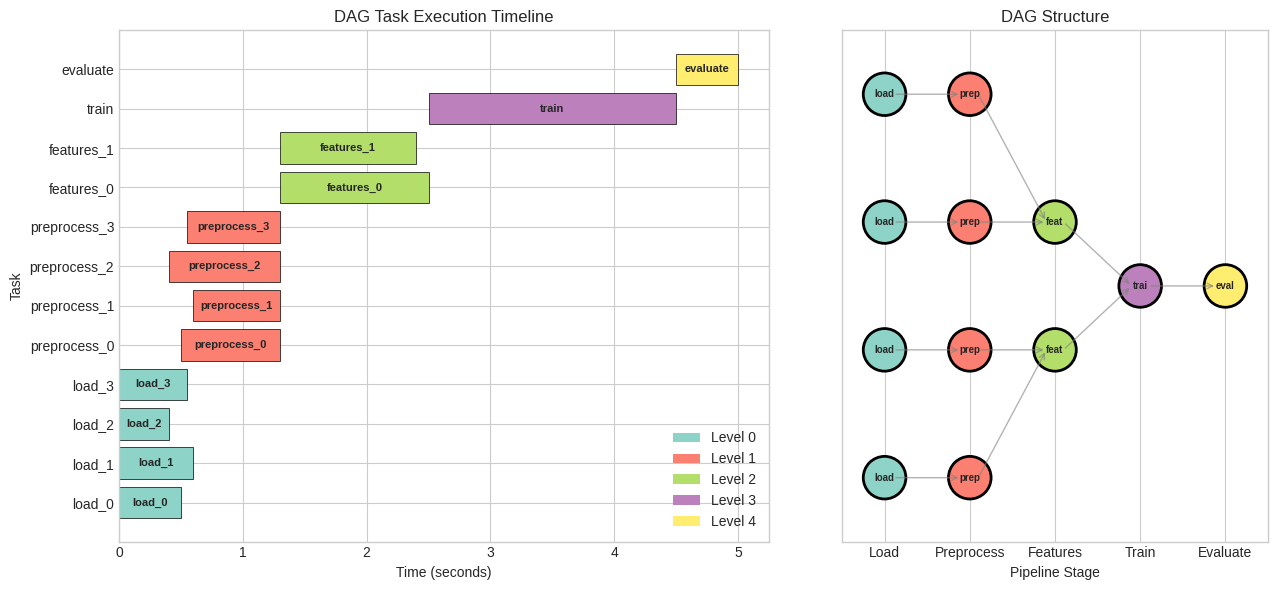


Total pipeline execution time: 5.00 seconds
Sum of individual task times: 10.00 seconds
Parallelization speedup: 2.00x


In [14]:
# Visualize DAG execution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Gantt chart of task execution
ax1 = axes[0]
colors = plt.cm.Set3(np.linspace(0, 1, 5))
level_colors = {0: colors[0], 1: colors[1], 2: colors[2], 3: colors[3], 4: colors[4]}

for i, (_, task) in enumerate(dag_df.iterrows()):
    ax1.barh(i, task['duration'], left=task['start_time'], 
             color=level_colors[task['level']], edgecolor='black', linewidth=0.5)
    ax1.text(task['start_time'] + task['duration']/2, i, task['task_id'], 
             ha='center', va='center', fontsize=8, fontweight='bold')

ax1.set_yticks(range(len(dag_df)))
ax1.set_yticklabels(dag_df['task_id'])
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Task')
ax1.set_title('DAG Task Execution Timeline')

# Add legend for levels
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=level_colors[i], label=f'Level {i}') for i in range(5)]
ax1.legend(handles=legend_elements, loc='lower right')

# 2. DAG structure visualization
ax2 = axes[1]

# Position tasks by level
level_counts = dag_df.groupby('level').size()
positions = {}
for level in range(5):
    level_tasks = dag_df[dag_df['level'] == level]['task_id'].tolist()
    n_tasks = len(level_tasks)
    for i, task_id in enumerate(level_tasks):
        x = level
        y = (i - (n_tasks - 1) / 2) * 1.5
        positions[task_id] = (x, y)

# Draw edges (dependencies)
for _, task in dag_df.iterrows():
    task_id = task['task_id']
    for dep in task['dependencies']:
        x1, y1 = positions[dep]
        x2, y2 = positions[task_id]
        ax2.annotate('', xy=(x2-0.1, y2), xytext=(x1+0.1, y1),
                     arrowprops=dict(arrowstyle='->', color='gray', alpha=0.6))

# Draw nodes
for task_id, (x, y) in positions.items():
    level = dag_df[dag_df['task_id'] == task_id]['level'].values[0]
    circle = plt.Circle((x, y), 0.25, color=level_colors[level], ec='black', linewidth=2)
    ax2.add_patch(circle)
    ax2.text(x, y, task_id.split('_')[0][:4], ha='center', va='center', fontsize=7, fontweight='bold')

ax2.set_xlim(-0.5, 4.5)
ax2.set_ylim(-3, 3)
ax2.set_aspect('equal')
ax2.set_xlabel('Pipeline Stage')
ax2.set_title('DAG Structure')
ax2.set_xticks(range(5))
ax2.set_xticklabels(['Load', 'Preprocess', 'Features', 'Train', 'Evaluate'])
ax2.set_yticks([])

plt.tight_layout()
plt.savefig('dask_dag_execution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTotal pipeline execution time: {dag_df['end_time'].max():.2f} seconds")
print(f"Sum of individual task times: {dag_df['duration'].sum():.2f} seconds")
print(f"Parallelization speedup: {dag_df['duration'].sum() / dag_df['end_time'].max():.2f}x")

## 6. Monitoring and Visualization <a id="monitoring"></a>

Demonstrates how to analyze worker utilization and task distribution.

In [15]:
# Simulate worker statistics
n_workers = 4
n_time_points = 50

np.random.seed(42)
time_points = np.arange(n_time_points)

# Generate worker utilization data
worker_data = []
for t in time_points:
    for w in range(n_workers):
        # Simulate varying utilization
        base_util = 0.6 + 0.2 * np.sin(t / 10 + w)
        cpu_util = np.clip(base_util + np.random.normal(0, 0.1), 0, 1)
        memory_util = np.clip(0.4 + 0.3 * cpu_util + np.random.normal(0, 0.05), 0, 1)
        tasks_running = int(cpu_util * 4)
        
        worker_data.append({
            'time': t,
            'worker': f'worker-{w}',
            'cpu_utilization': cpu_util,
            'memory_utilization': memory_util,
            'tasks_running': tasks_running
        })

worker_df = pd.DataFrame(worker_data)
worker_df.head(10)

,time,worker,cpu_utilization,memory_utilization,tasks_running
0,0,worker-0,0.649671,0.587988,2
1,0,worker-1,0.833063,0.726070,3
2,0,worker-2,0.758444,0.615826,3
3,0,worker-3,0.786145,0.674215,3
4,1,worker-0,0.573019,0.599034,2
5,1,worker-1,0.731900,0.596283,2
6,1,worker-2,0.796838,0.543387,3
7,1,worker-3,0.435824,0.502633,1
8,2,worker-0,0.538451,0.577248,2
9,2,worker-1,0.695605,0.538066,2


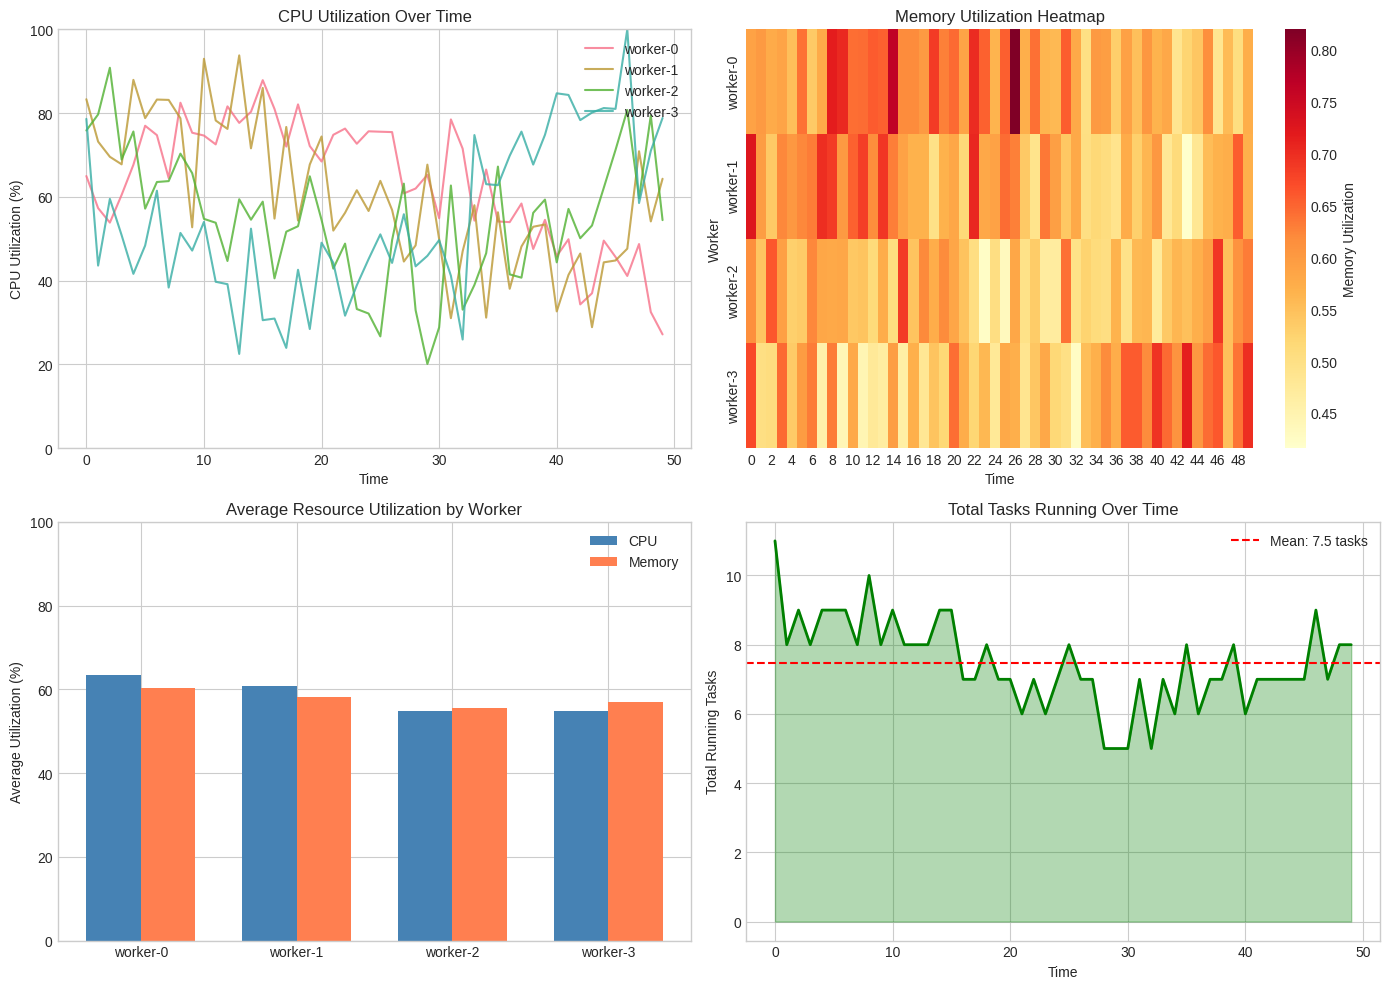


Worker Statistics Summary:
Average CPU utilization: 58.4%
Average memory utilization: 57.7%
Peak concurrent tasks: 11


In [16]:
# Visualize worker monitoring data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. CPU utilization over time by worker
ax1 = axes[0, 0]
for worker in worker_df['worker'].unique():
    data = worker_df[worker_df['worker'] == worker]
    ax1.plot(data['time'], data['cpu_utilization'] * 100, label=worker, alpha=0.8)
ax1.set_xlabel('Time')
ax1.set_ylabel('CPU Utilization (%)')
ax1.set_title('CPU Utilization Over Time')
ax1.legend(loc='upper right')
ax1.set_ylim(0, 100)

# 2. Memory utilization heatmap
ax2 = axes[0, 1]
pivot_memory = worker_df.pivot(index='worker', columns='time', values='memory_utilization')
sns.heatmap(pivot_memory, cmap='YlOrRd', ax=ax2, cbar_kws={'label': 'Memory Utilization'})
ax2.set_xlabel('Time')
ax2.set_ylabel('Worker')
ax2.set_title('Memory Utilization Heatmap')

# 3. Average utilization by worker
ax3 = axes[1, 0]
avg_util = worker_df.groupby('worker').agg({
    'cpu_utilization': 'mean',
    'memory_utilization': 'mean'
}).reset_index()

x = np.arange(len(avg_util))
width = 0.35
ax3.bar(x - width/2, avg_util['cpu_utilization'] * 100, width, label='CPU', color='steelblue')
ax3.bar(x + width/2, avg_util['memory_utilization'] * 100, width, label='Memory', color='coral')
ax3.set_xticks(x)
ax3.set_xticklabels(avg_util['worker'])
ax3.set_ylabel('Average Utilization (%)')
ax3.set_title('Average Resource Utilization by Worker')
ax3.legend()
ax3.set_ylim(0, 100)

# 4. Task distribution over time
ax4 = axes[1, 1]
total_tasks = worker_df.groupby('time')['tasks_running'].sum()
ax4.fill_between(total_tasks.index, total_tasks.values, alpha=0.3, color='green')
ax4.plot(total_tasks.index, total_tasks.values, 'g-', linewidth=2)
ax4.axhline(total_tasks.mean(), color='red', linestyle='--', 
            label=f'Mean: {total_tasks.mean():.1f} tasks')
ax4.set_xlabel('Time')
ax4.set_ylabel('Total Running Tasks')
ax4.set_title('Total Tasks Running Over Time')
ax4.legend()

plt.tight_layout()
plt.savefig('dask_worker_monitoring.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nWorker Statistics Summary:")
print(f"Average CPU utilization: {worker_df['cpu_utilization'].mean()*100:.1f}%")
print(f"Average memory utilization: {worker_df['memory_utilization'].mean()*100:.1f}%")
print(f"Peak concurrent tasks: {worker_df.groupby('time')['tasks_running'].sum().max()}")

## Summary

This notebook demonstrated using QTau with Dask for:

1. **Basic task distribution** with prime counting and computational tasks
2. **Parallel data processing** with chunk-based MapReduce patterns
3. **Distributed NumPy operations** for matrix computations
4. **Task dependencies and DAGs** with complex pipelines
5. **Worker monitoring** and resource utilization analysis

### Key Takeaways

- Dask is excellent for data-parallel workloads and complex DAGs
- QTau provides a unified interface for Dask cluster management
- Task scheduling respects dependencies automatically
- Monitoring helps identify bottlenecks and optimize resource usage